In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
# 載入資料時，根據輸入的 key (train or val) 選擇要轉換的格式
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #torch中轉換成tensor是將圖片轉成'channel''image high''image width'這樣的順序
    # numpy畫圖則是要'image high''image width''channel'
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean #把輸入照片時的轉變倒轉回去
    inp = np.clip(inp, 0, 1) #把最小值和最大值設定在 0 和 1 之間
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time() #在訓練前抓一個時間

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']: #根據兩種模式開啟模式，並且用於決定後續內容是否執行
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad() #將優化器的參數歸零

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): # 括號內條件成立時啟動autogradient，用法為with torch.no_grad()的相反
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() #真正執行權重修正

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc: #過程中把最好ㄉ結果存起來
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since #訓練前後的時間相減
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft= model_ft.to(device)
                        
criterion = nn.CrossEntropyLoss()
                        
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=3)

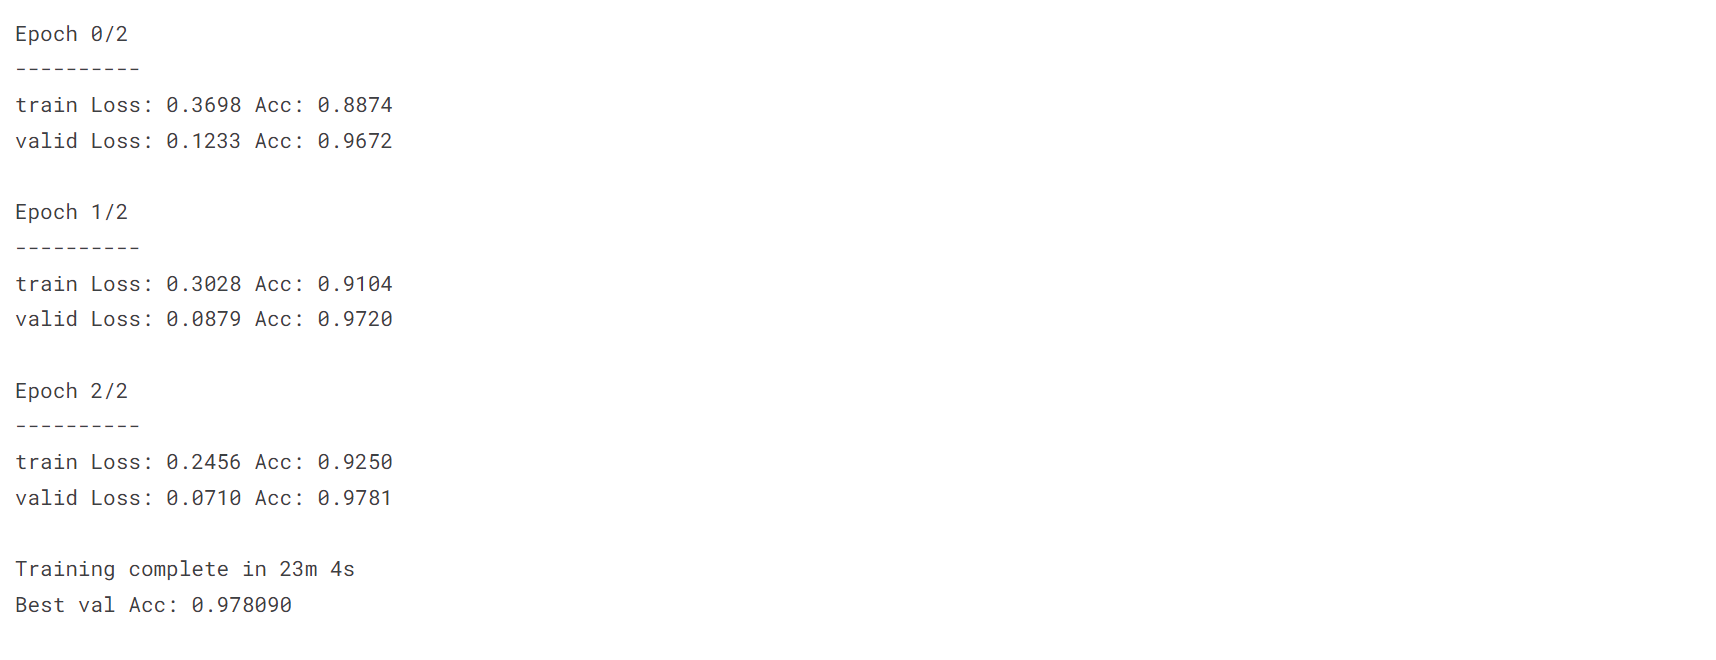

In [ ]:
torch.save(model_ft.state_dict(), 'plant_disease_wts.pt')

In [1]:
def create_custom_resnet18(out_features, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, out_features)
    return model

In [ ]:
model_loaded = create_custom_resnet18(len(class_names))

weights=torch.load('plant_disease_wts.pt',map_location=torch.device('cpu'))
model_loaded.load_state_dict(weights)
model_loaded.eval()

In [ ]:
num=5 #要列印幾張
model=model_loaded #要套用哪個模型

test_path="../input/new-plant-diseases-dataset/test/test"
test_imgs={x: Image.open(os.path.join(test_path,x)) for x in os.listdir(test_path)}

labels=[]
imgs=[]
for label,img in random.sample(test_imgs.items(), num): #隨機取五張
    labels.append(label)
    imgs.append(img)

for i,img in enumerate(imgs):
    img_t = data_transforms['valid'](img) #用跟valid一樣的方式轉換
    batch_t = torch.unsqueeze(img_t, 0)
    model.eval( )
    out = model(batch_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    #畫圖
    plt.figure(figsize=(15,15))
    ax = plt.subplot(1,num,i+1)
    ax.axis('off')
    ax.set_title("Label:{} \n Predict:{} \n Probability:{:.2f}%".format(
        labels[i].split('.')[0],class_names[index[0]],percentage[index[0]].item()))
    plt.tight_layout()
    ax.imshow(img)

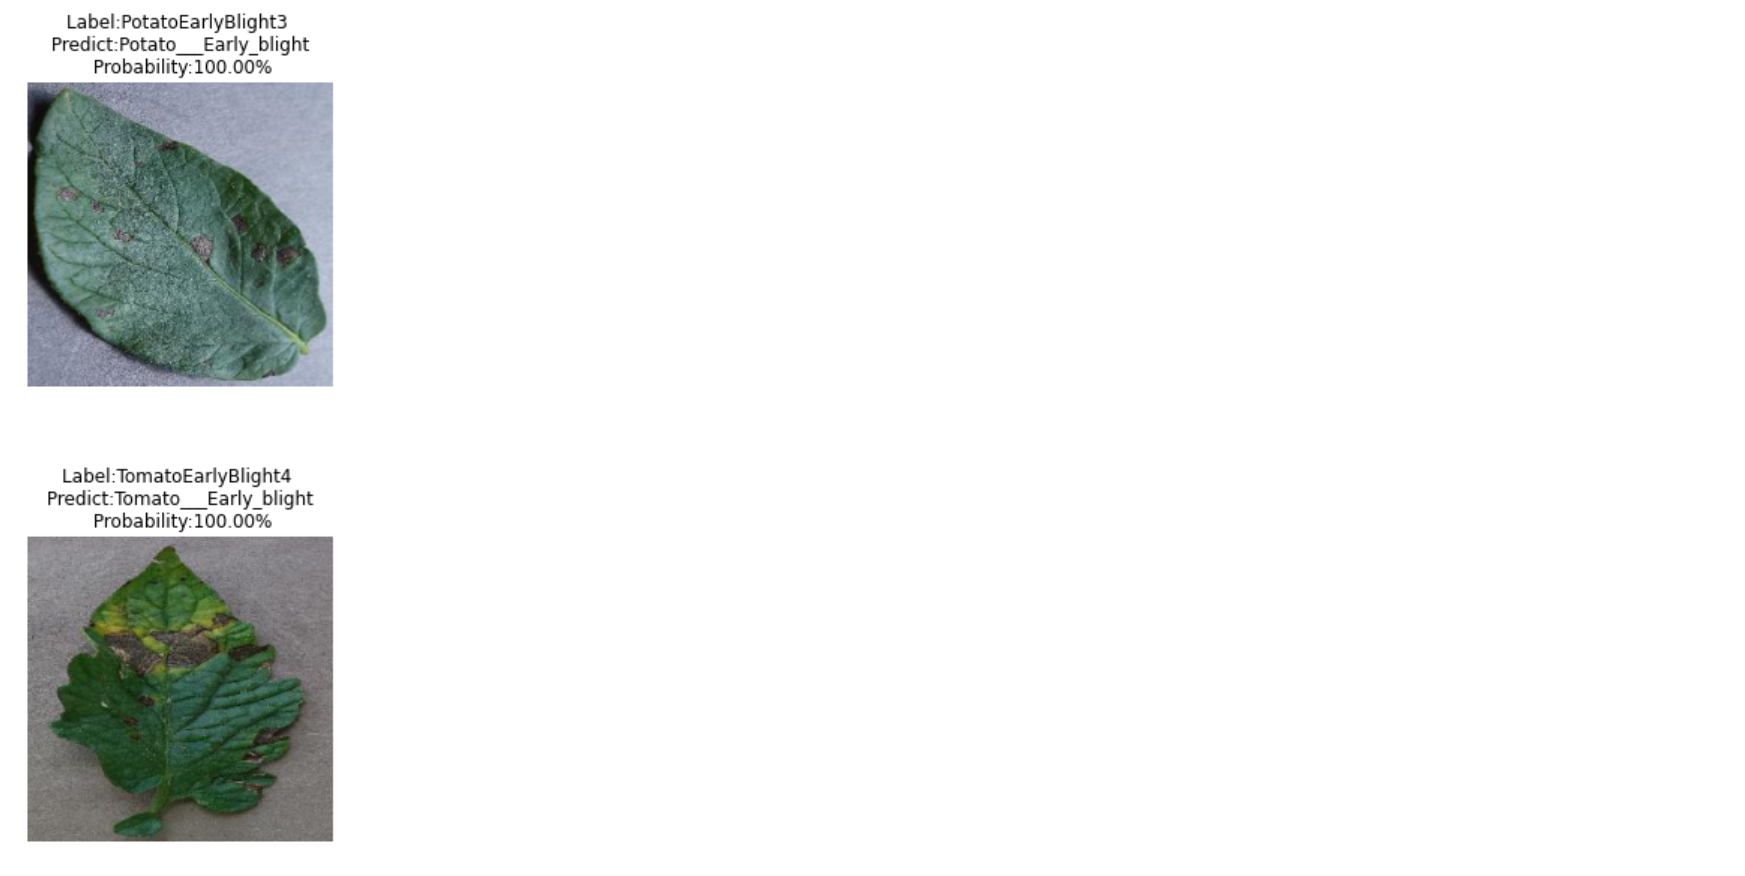
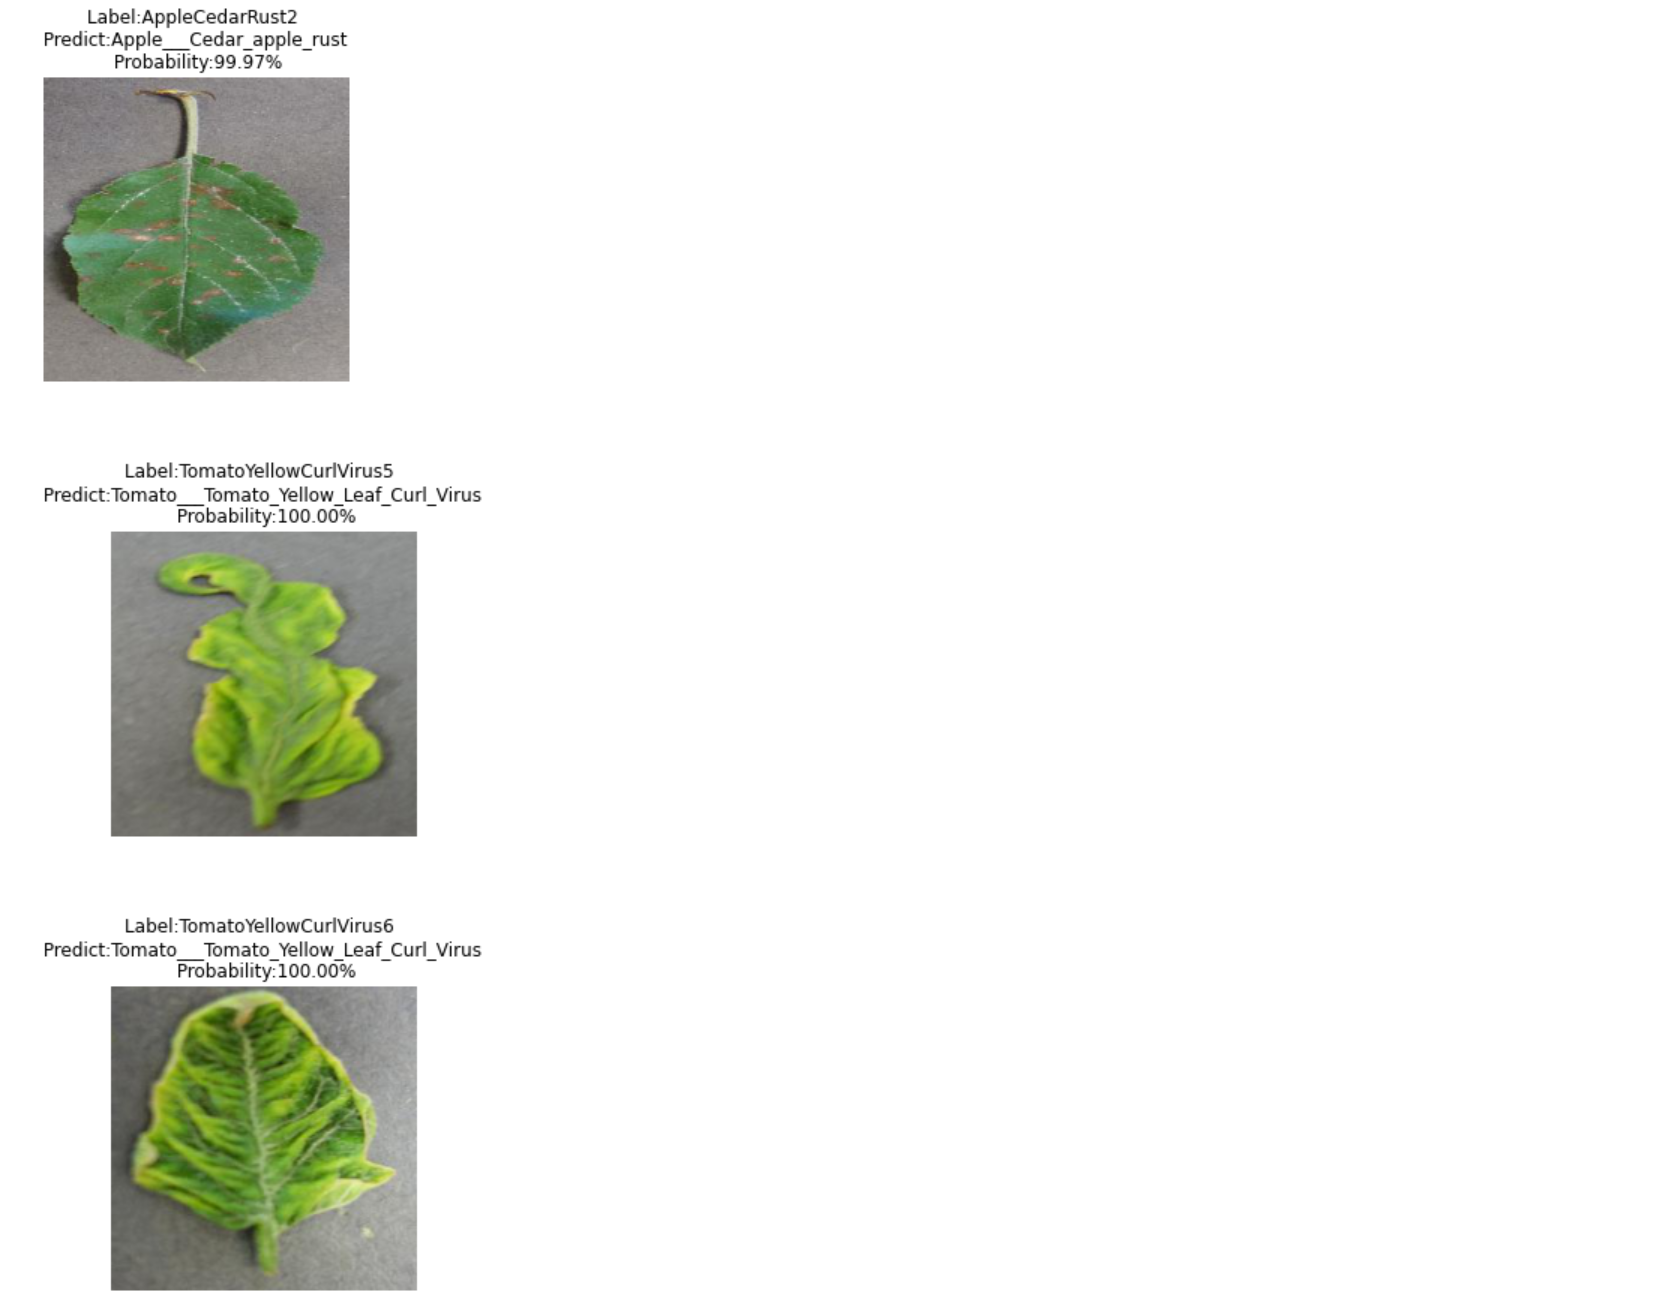